## Start and prepare EC2 instances

In this notebook instruction are provided to start three EC2 instanes. On all three the same packages have to be installed. For this we use a the `userdata` section.

Go to the EC2 in the management console. 

Go to instances and click `Launch instances`

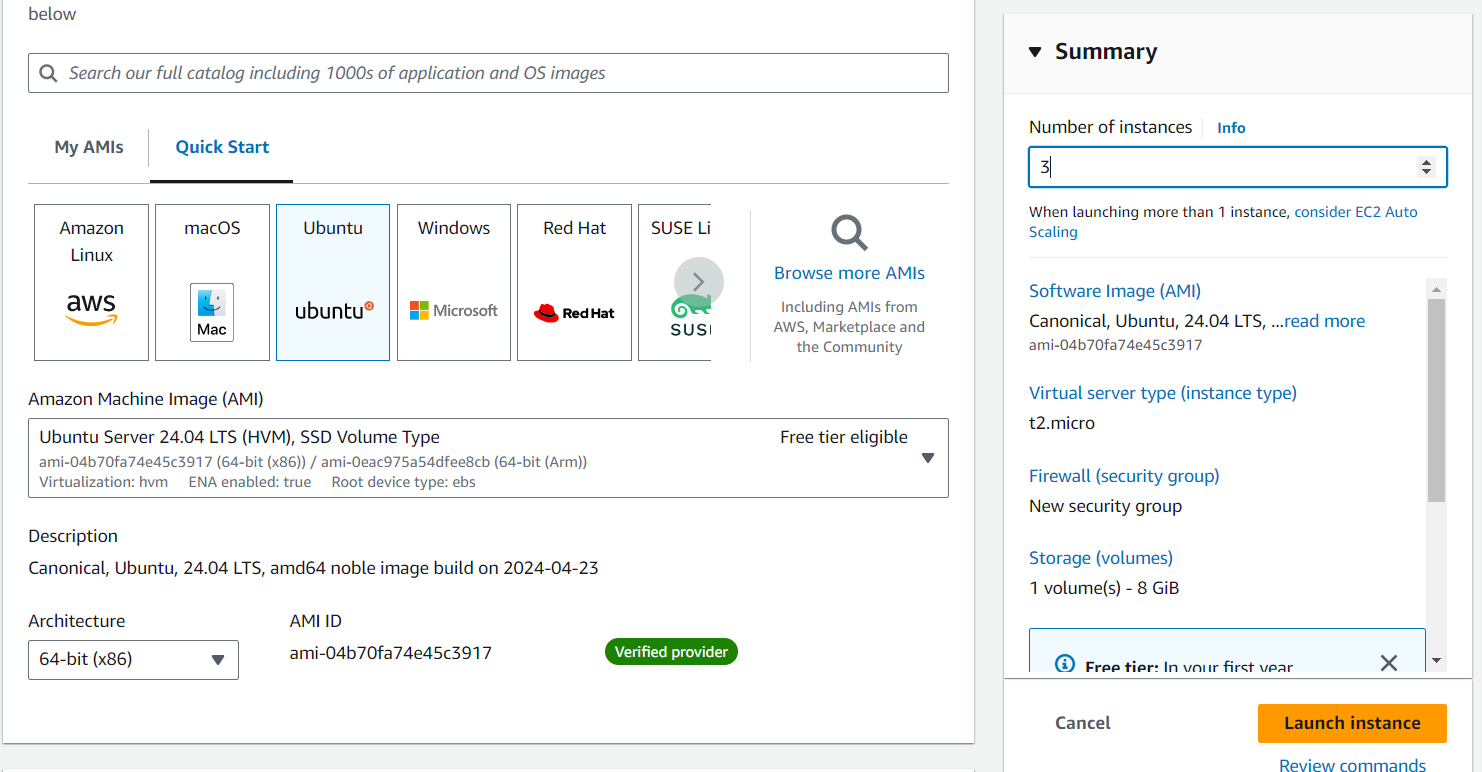

go down and make sure you select or create a `Key pair`

go down and under `Advanced details` go to the user data (at the bottom)

```
#!/bin/bash
sudo apt update
sudo apt upgrade -y
sudo apt install python3-pip -y
sudo apt install python3-distributed -y
sudo  apt install python3.12-venv -y

python3 -m venv .venv
source .venv/bin/activate
python3 -m pip install "dask[complete]"
python3 -m pip install bokeh!=3.0.*,>=2.4.2
```

#### improved script

I used ChatGPT to create a slightly improved script that installs specific versions.

When we log into the instance we are logged in as `ubuntu` user. you can cd .. twice to get to the root where the `.venv` folder is.

To start the enviroment type `source .venv/bin/activate`. Do this for the scheduler and the worker.

```
#!/bin/bash
# Update and upgrade system packages
sudo apt update
sudo apt upgrade -y

# Add PPA for Python 3.10 to install it from a trusted source
sudo add-apt-repository ppa:deadsnakes/ppa -y
sudo apt update

# Install Python 3.10 and related packages like venv, dev headers, and pip
sudo apt install python3.10 python3.10-venv python3.10-dev python3-pip -y

# Create and activate Python 3.10 virtual environment
python3.10 -m venv .venv
source .venv/bin/activate

# Upgrade pip, setuptools, and wheel to the latest versions for compatibility
python3 -m pip install --upgrade pip setuptools wheel

# Install specific version of Dask (2024.2.1) and ensure a compatible version of Bokeh
python3 -m pip install "dask[complete]==2024.2.1"
python3 -m pip install "bokeh!=3.0.*,>=2.4.2"
```

Launche the instances

Give the first instance the name `dask-scheduler` and the other two instances the name `dask-worker`

the user data instruction have been tested on an EC2 instance and they all worked. 

Due to the userdata starting the instances might take a bit longer.

## Opening port in the security group

Since the instances are all started at the same time they are all related to the same security group.

The security group can be found by selecting one of the instances and then go the the security tab.

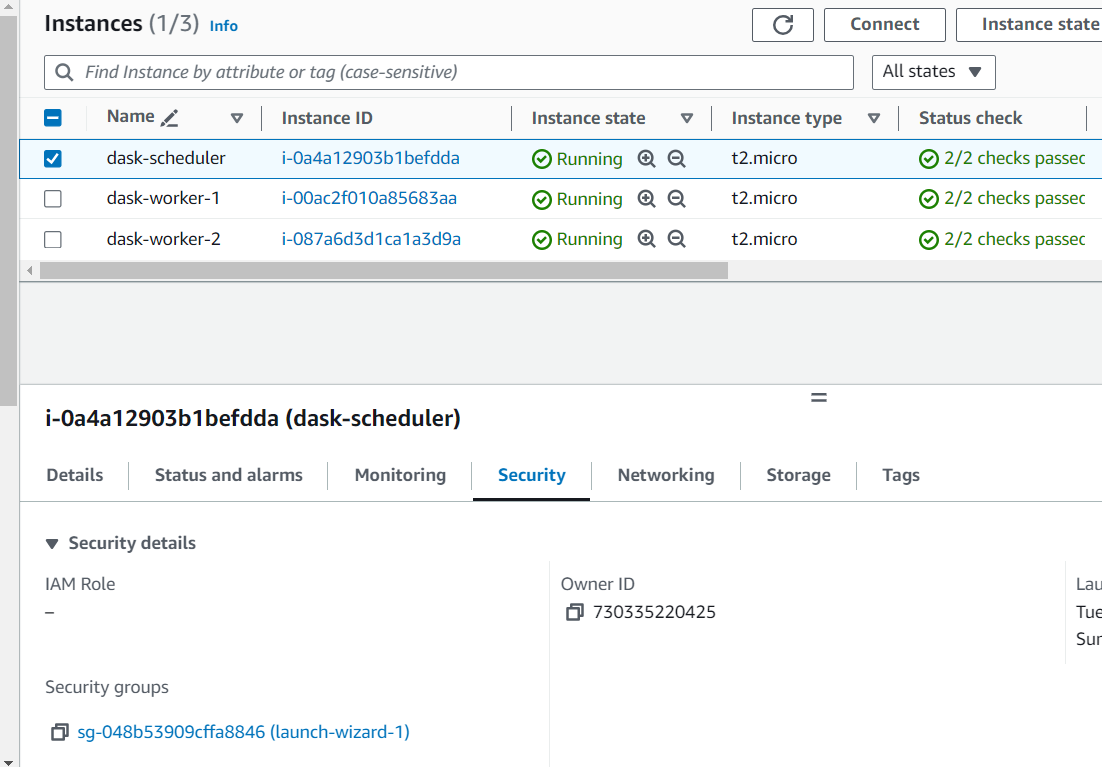

open the security group and go to `Edit Inbound Rules` under `Inbound Rules` then `Add Rule`. Add some rules and make sure it looks like in the image below

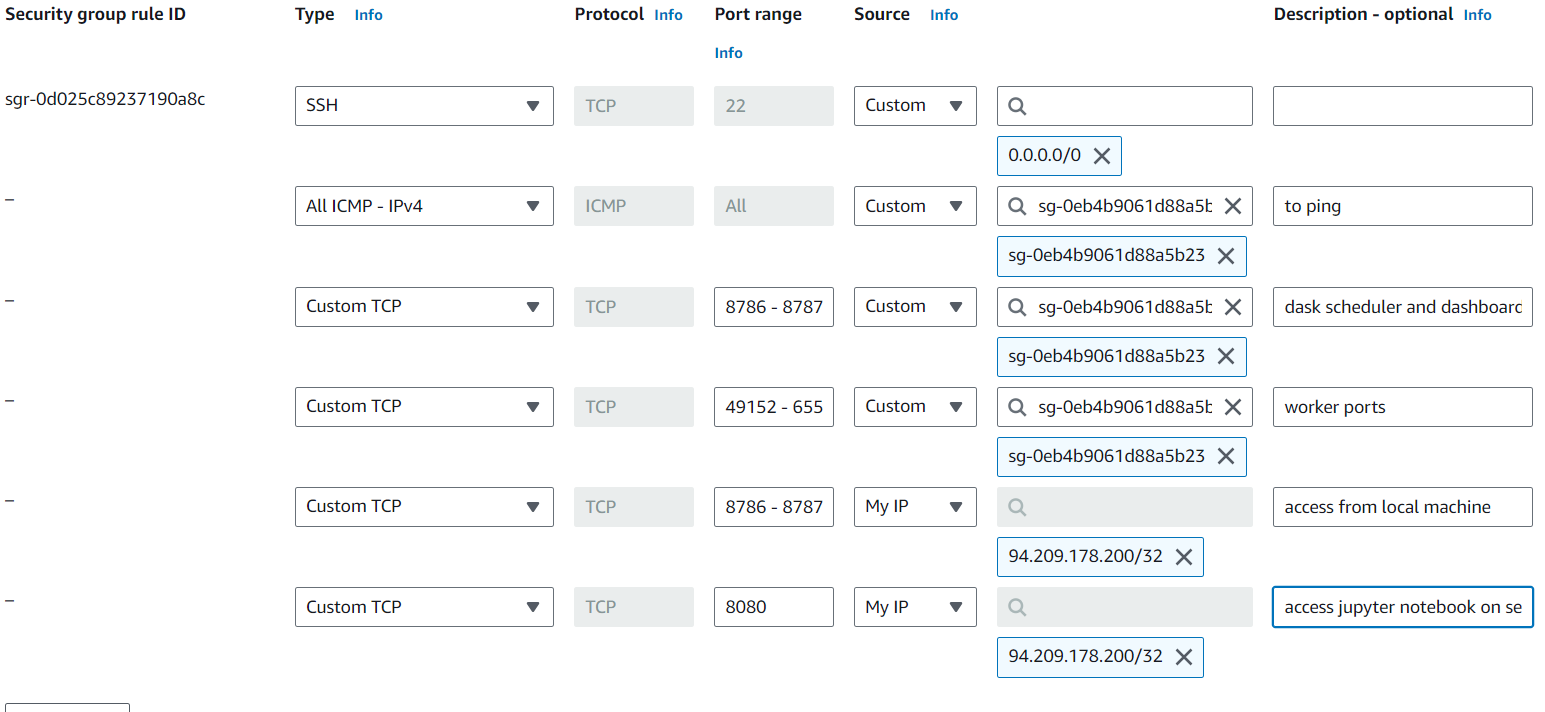

The unreadable part states port `49152-65535`

click save rules

log into the dask scheduler instance and try to ping the workers usine

`ping <private-ip-adress`

On my machine both pinged correctly.

## Setting up cluster with the CLI

log into each instance using for example Putty

in the terminal of the scheduler instance type:

`dask scheduler` 

this should among other show the something like below

```
2024-06-25 14:53:43,235 - distributed.scheduler - INFO -   Scheduler at:  tcp://172.31.21.203:8786
2024-06-25 14:53:43,235 - distributed.scheduler - INFO -   dashboard at:  http://172.31.21.203:8787/status
```

on each worker now execute

`dask worker tcp://172.31.21.203:8786`

this should return among others output that contains

```
2024-06-25 14:59:22,385 - distributed.nanny - INFO -         Start Nanny at: 'tcp://172.31.24.71:33373'
2024-06-25 14:59:23,015 - distributed.worker - INFO -       Start worker at:   tcp://172.31.24.71:46673
2024-06-25 14:59:23,016 - distributed.worker - INFO -          Listening to:   tcp://172.31.24.71:46673
2024-06-25 14:59:23,016 - distributed.worker - INFO -          dashboard at:         172.31.24.71:35887
2024-06-25 14:59:23,016 - distributed.worker - INFO - Waiting to connect to:   tcp://172.31.21.203:8786
2024-06-25 14:59:23,016 - distributed.worker - INFO - -------------------------------------------------
2024-06-25 14:59:23,017 - distributed.worker - INFO -               Threads:                          1
2024-06-25 14:59:23,017 - distributed.worker - INFO -                Memory:                   0.94 GiB
2024-06-25 14:59:23,017 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-9tb94gip
2024-06-25 14:59:23,017 - distributed.worker - INFO - -------------------------------------------------
2024-06-25 14:59:23,277 - distributed.worker - INFO - Starting Worker plugin shuffle
2024-06-25 14:59:23,278 - distributed.worker - INFO -         Registered to:   tcp://172.31.21.203:8786
2024-06-25 14:59:23,278 - distributed.worker - INFO - -------------------------------------------------
2024-06-25 14:59:23,279 - distributed.core - INFO - Starting established connection to tcp://172.31.21.203:8786
```



now the cluster is ready with one scheduler and 2 workers

Now we can see the daskboard using the **public ip** (not the private) 

`http://34.229.148.157:8787/status`

on this tab `workers`

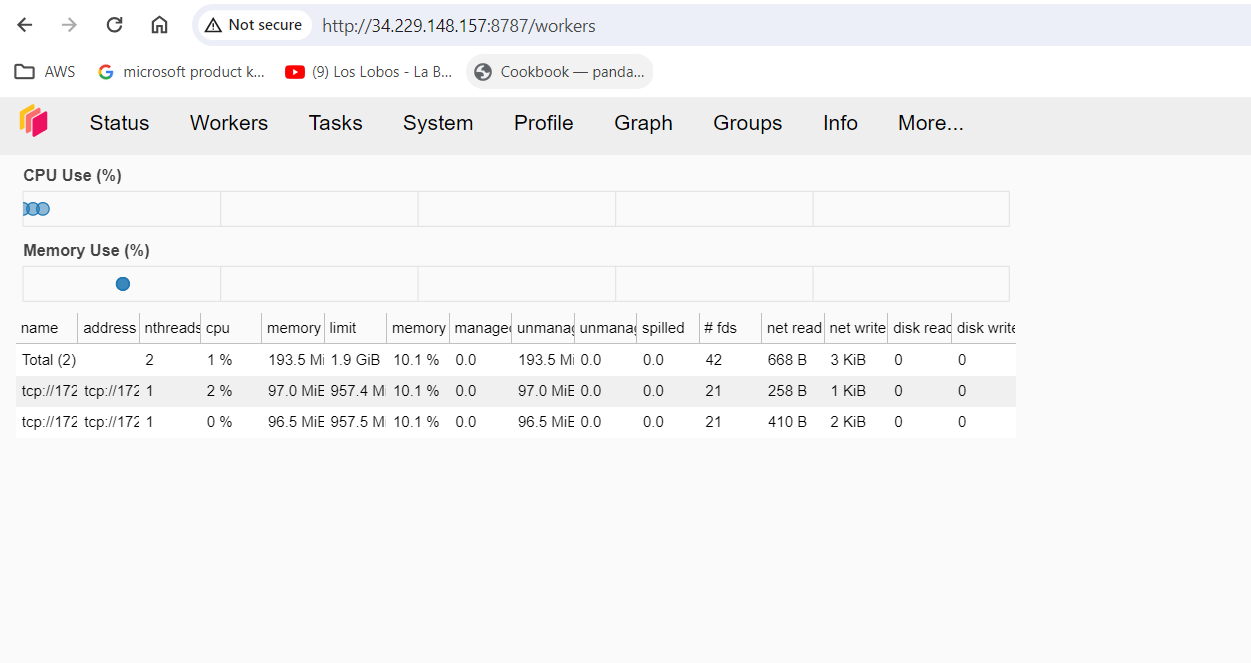

### Remark

The user data is really installed in the root while we using Putty we log in as `ubuntu` user in the directory `/home/ubuntu`. To get to the root directory we need to do cd .. twice. In this directory the `.venv` directory can be found.
To start the environment type 

`source .venv/bin/activate`

Then use the url above with the **public ip** of the scheduler node you created. 

## Install the AWS CLI

check the link below to install the aws cli:

https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html

you still need to assign roles to the EC2 instance if you want to access data in s3. After that you can test if it works by typing

`aws s3 ls` 

This will show any buckets in your account

# Connect locally to the scheduler

Now we try to connect from our local computer to the dask cluster. Please make sure that you use the **public IP** of the scheduler and not the private IP.

In [17]:
from dask.distributed import Client

address = "tcp://107.23.31.110:8786"

client = Client(address=address)

client

/home/sacha/.cache/pypoetry/virtualenvs/sacha-JWjbAAeO-py3.10/lib/python3.10/site-packages/distributed/client.py:1394: VersionMismatchWarning: Mismatched versions found

+---------+-----------------+----------------+----------------+
| Package | Client          | Scheduler      | Workers        |
+---------+-----------------+----------------+----------------+
| python  | 3.10.12.final.0 | 3.12.3.final.0 | 3.12.3.final.0 |
+---------+-----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


<Client: 'tcp://172.31.17.202:8786' processes=2 threads=2, memory=1.87 GiB>

2024-06-27 20:29:23,765 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [15]:
import dask.dataframe as dd



In [16]:
client.close()

# Run jupyter 

Now we want to run a jupyter notebook on the dask scheduler and connect to the cluster using a jupyter notebook on the scheduler (ideally you might want to setup the cluster and connect to it from your local machine - to be done). To create on an EC2 instance that runs jupyter and to which you can connect from your local machine you have to
- install jupyter on the server - use PuTTy to log into our dask-scheduler
- open up port 8080 (or another)
- execute the following command on the server - `jupyter notebook --no-browser --port=8080 --ip=0.0.0.0 --allow-root`

what is key is `--ip=0.0.0.0` without it will not work (several tries with different options)

The output will something like

` http://127.0.0.1:8080/tree?token=ea112db195c9c58c4a2043aac3b52b3897fab80dbf546e12`

replace the `127.0.0.1` with the external IP adress of the server and execute the whole expression in your local browser. Now you should be connected to the server notebook.

In [2]:
from dask.distributed import Client

In [3]:
client = Client()

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.54 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46819,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: 18 hours ago,Total memory: 15.54 GiB
Comm: tcp://127.0.0.1:45033,Total threads: 3
Dashboard: http://127.0.0.1:38525/status,Memory: 3.88 GiB
Nanny: tcp://127.0.0.1:37181,


In [6]:
client.close()